## XGBoost + RandomForest

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('merged_data_advb.csv')

C:\Users\polin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

In [3]:
data['standartized_diagnosis_len'].fillna(0, inplace = True)
data['service_code'].fillna('', inplace = True)
data['folk_1_code'].fillna('', inplace = True)
data['folk_2_code'].fillna('', inplace = True)
data['service_level_3_category_hash'].fillna('', inplace = True)
data['service_level_2_category_hash'].fillna('', inplace = True)
data.drop(columns = ['diagnosis_uuid',
                     'diagnosis_category_level_3_hash', 'diagnosis_category_level_1_hash', 'folk_3_code', 'folk_4_code']
         , inplace = True)

In [4]:
data.isna().any()

Unnamed: 0                       False
created_at                       False
status                           False
guarant_letter_uuid              False
comment_len                      False
is_paid_by_patient               False
patient_id                       False
has_doctor                       False
doctor_len                       False
diagnosis_len                    False
diagnosis_clarification_len      False
standartized_diagnosis_len       False
service_status                   False
service_quantity                 False
service_code                     False
folk_1_code                      False
folk_2_code                      False
service_level_3_category_hash    False
service_level_2_category_hash    False
service_level                    False
дата убытка                      False
loss                             False
dtype: bool

Попробуем обучить модели на данных, в которых каждой записи сопоставляем затраты за весь день.

Делим выборку на терйн и тест:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
y_train = X_train['loss']
y_test = X_test['loss']

Функция для получения названий признаков после кодирования:

In [6]:
import sklearn
import warnings

def get_feature_names(column_transformer):
    def get_names(trans):
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    feature_names = []
    
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            _names = get_feature_names(trans)
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

### XGBoost

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


categorical_features = ["created_at", "status", "guarant_letter_uuid", "is_paid_by_patient", "has_doctor", 
                       "service_code", "folk_1_code", "folk_2_code", "service_level_3_category_hash", 
                       "service_level_2_category_hash"]

numeric_features = ["comment_len", "doctor_len", "diagnosis_len", "diagnosis_clarification_len", "standartized_diagnosis_len",
                    "service_status", "service_quantity", "service_level"]

features = numeric_features + categorical_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(max_depth = 70))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.5956914056142824 
 MAE =  2.4223178961711453 
 MSE =  13.951889567372515 
 RMSE =  3.735222827004102 
 MAPE =  0.7599406074363533


Посмотрим на важность признаков

<ipython-input-6-363329593584>:20: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


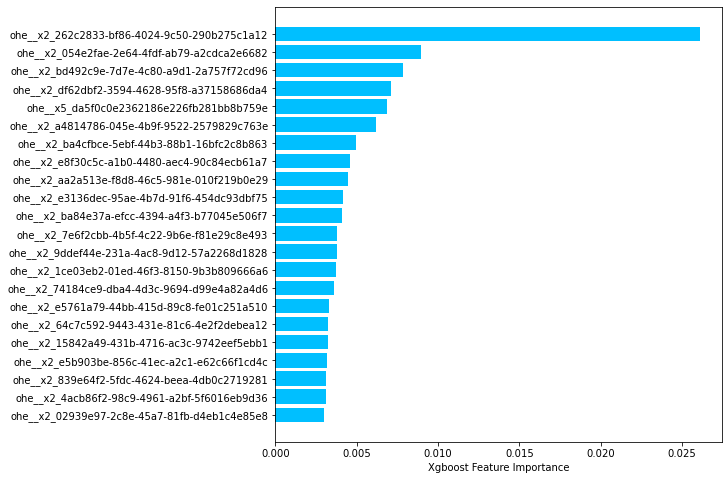

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8,8)

sorted_idx = pipeline[1].feature_importances_.argsort()[61616:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Xgboost Feature Importance")
plt.show()

### RandomForest

In [19]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestRegressor(max_depth = 10))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.10099185728589 
 MAE =  3.62482052290195 
 MSE =  31.02299209437487 
 RMSE =  5.56982873115277 
 MAPE =  1.1332731598291719


Посмотрим на важность признаков

<ipython-input-6-363329593584>:20: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


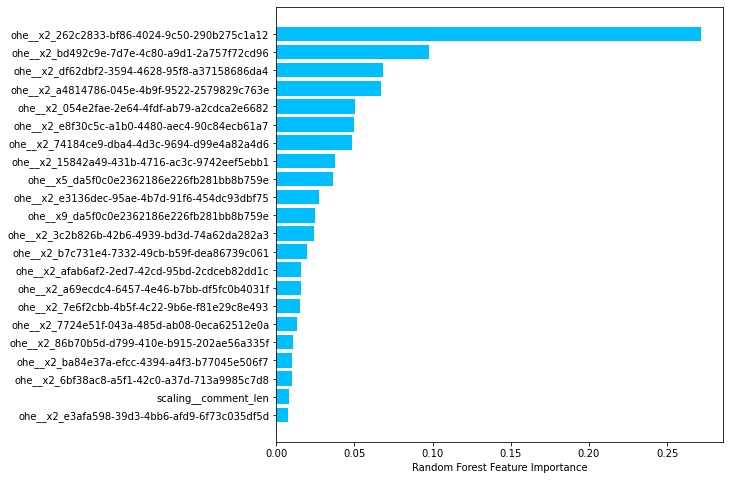

In [21]:
sorted_idx = pipeline[1].feature_importances_.argsort()[61616:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Random Forest Feature Importance")
plt.show()

Теперь в качестве лосса будем брать среднее значение затрат за день

In [22]:
data_patient = data.groupby(['created_at', 'patient_id']).size().reset_index()
data_patient

,created_at,patient_id,0
0,2020-07-01,15694,5
1,2020-07-01,16169,2
2,2020-07-01,17033,7
3,2020-07-01,18221,1
4,2020-07-01,24403,1
...,...,...,...
52250,2022-02-28,198258,6
52251,2022-02-28,199352,1
52252,2022-02-28,200276,5
52253,2022-02-28,200277,4


In [23]:
data_new = data.merge(data_patient, left_on=['created_at', 'patient_id'], right_on=['created_at', 'patient_id'], how='left')

In [24]:
data_new['loss'] = data_new.apply(lambda x: x['loss'] / x[0], axis=1)

In [25]:
X_train, X_test = train_test_split(data_new, test_size=0.2, random_state = 42)
y_train = X_train['loss']
y_test = X_test['loss']

### XGBoost

In [26]:
categorical_features = ["created_at", "status", "guarant_letter_uuid", "is_paid_by_patient", "has_doctor", 
                       "service_code", "folk_1_code", "folk_2_code", "service_level_3_category_hash", 
                       "service_level_2_category_hash"]

numeric_features = ["comment_len", "doctor_len", "diagnosis_len", "diagnosis_clarification_len", "standartized_diagnosis_len",
                    "service_status", "service_quantity", "service_level"]

features = numeric_features + categorical_features

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(max_depth = 70))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.3336377206295259 
 MAE =  0.8774296644316377 
 MSE =  4.521778937083326 
 RMSE =  2.1264474921999192 
 MAPE =  1.280357787285505


<ipython-input-6-363329593584>:20: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


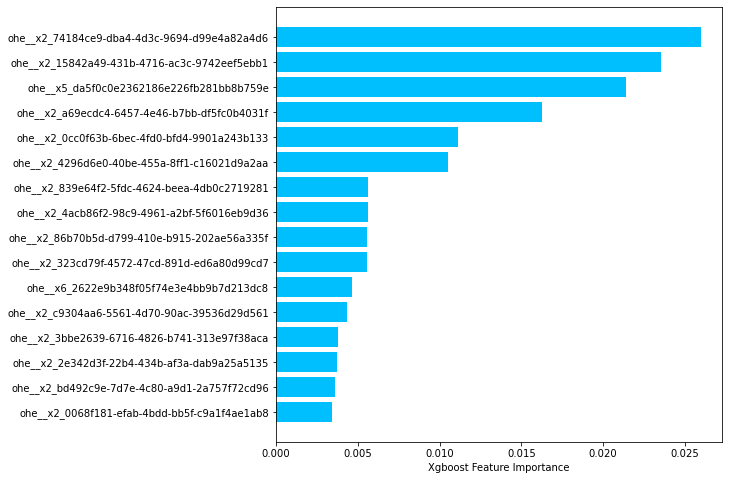

In [31]:
plt.rcParams["figure.figsize"] = (8,8)

sorted_idx = pipeline[1].feature_importances_.argsort()[61490:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Xgboost Feature Importance")
plt.show()

### RandomForest

In [32]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestRegressor(max_depth = 10))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print("R2 = ", r2_score(y_test, y_pred), "\n", "MAE = ",  mean_absolute_error(y_test, y_pred), '\n',
     "MSE = ", mean_squared_error(y_test, y_pred), '\n', "RMSE = ", mean_squared_error(y_test, y_pred, squared = False), '\n',
      "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

R2 =  0.16420976270938836 
 MAE =  1.11066857235425 
 MSE =  5.671477524764614 
 RMSE =  2.381486410787308 
 MAPE =  2.1324087811347012


<ipython-input-6-363329593584>:20: UserWarning: Transformer scaling (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


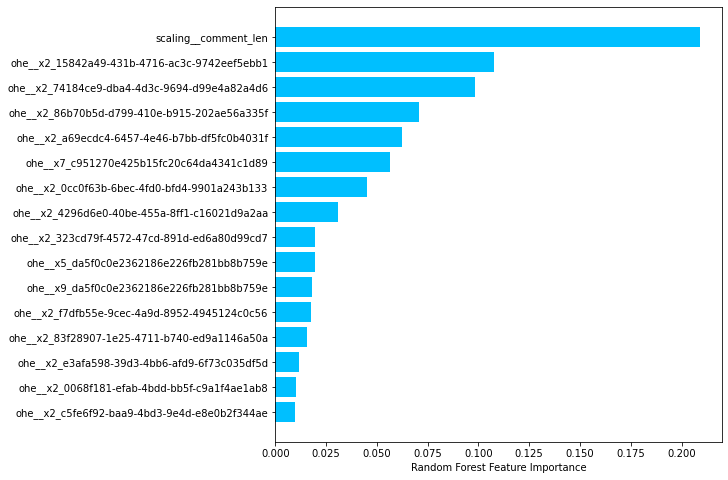

In [33]:
sorted_idx = pipeline[1].feature_importances_.argsort()[61490:]
plt.barh(np.array(get_feature_names(column_transformer))[sorted_idx],\
        pipeline[1].feature_importances_[sorted_idx], color='deepskyblue')
plt.xlabel("Random Forest Feature Importance")
plt.show()